In [29]:
import pandas as pd
import numpy as np
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

### 1 часть

Цель: научиться использовать метод сингулярного разложения (SVD) для 
построения рекомендательной системы, а также оценить качество полученной 
модели на реальных данных.

1. Подготовка данных

Загрузите набор данных MovieLens (например, ml-latest-small.zip) с 
официального сайта MovieLens: https://grouplens.org/datasets/movielens/latest/

Изучите структуру данных: идентификаторы пользователей, 
идентификаторы фильмов, рейтинги и временные метки.

In [2]:
movies = pd.read_csv('data/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
links = pd.read_csv('data/ml-latest-small/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
tags = pd.read_csv('data/ml-latest-small/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


2. Предобработка данных

Очистите данные, удалив пустые значения и неактуальные записи. 
Постройте матрицу рейтингов, где строки соответствуют пользователям, а 
столбцы — фильмам. Заполните недостающие значения нулями или оставьте их 
пустыми.

In [6]:
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [7]:
ratings.isna().sum().sum(), movies.isna().sum().sum(), tags.isna().sum().sum()

(0, 0, 0)

In [8]:
ratings['userId'].value_counts()

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
207      20
442      20
53       20
576      20
595      20
Name: count, Length: 610, dtype: int64

In [9]:
min_movie_ratings = 10
movie_counts = ratings['movieId'].value_counts()
active_movies = movie_counts[movie_counts >= min_movie_ratings].index
ratings = ratings[ratings['movieId'].isin(active_movies)]
ratings.shape

(81116, 4)

In [10]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [11]:
genre_dummies = movies['genres'].str.get_dummies(sep='|')
movies = pd.concat([movies, genre_dummies], axis=1)
movies.shape

(9742, 23)

In [12]:
merged = ratings.merge(movies, on="movieId", how="left")
merged.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [13]:
user_item_matrix = merged.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix.head()

movieId,1,2,3,5,6,7,9,10,11,12,...,166461,166528,166643,168250,168252,174055,176371,177765,179819,187593
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3. Реализация SVD

Используйте библиотеку Surprise, NumPy или SciPy для выполнения SVD 
на матрице рейтингов.

In [21]:
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

algo = SVD(n_factors=100, n_epochs=20, random_state=42)

algo.fit(trainset)

predictions = algo.test(testset)

4. Оценка рекомендательной системы

Оцените качество модели, используя метрики, такие как RMSE, Precision, 
Recall, NDCG и др. 
Постройте графики или таблицы, чтобы проиллюстрировать результаты.

In [25]:
rmse = accuracy.rmse(predictions)

threshold = 3.5
k = 10

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) 
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / (n_rec_k + 1e-10)
        recalls[uid] = n_rel_and_rec_k / (n_rel + 1e-10)
    return precisions, recalls

def ndcg_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        
    ndcgs = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        dcg = 0.0
        for i, (est, true_r) in enumerate(user_ratings[:k]):
            if true_r >= threshold:
                dcg += 1.0 / np.log2(i + 2)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        idcg = sum((1.0 / np.log2(i + 2) for i in range(min(n_rel, k))))
        ndcgs[uid] = dcg / (idcg + 1e-10)
    return ndcgs

precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=threshold)
ndcgs = ndcg_at_k(predictions, k=k, threshold=threshold)

avg_precision = np.mean(list(precisions.values()))
avg_recall = np.mean(list(recalls.values()))
avg_ndcg = np.mean(list(ndcgs.values()))

print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")
print(f"Average NDCG@{k}: {avg_ndcg:.4f}")

RMSE: 0.8470
Average Precision@10: 0.7504
Average Recall@10: 0.5086
Average NDCG@10: 0.8436


In [26]:
results_df = pd.DataFrame({
    'Metric': ['RMSE', f'Precision@{k}', f'Recall@{k}', f'NDCG@{k}'],
    'Value': [rmse, avg_precision, avg_recall, avg_ndcg]
})

results_df

,Metric,Value
0,RMSE,0.846957
1,Precision@10,0.750412
2,Recall@10,0.508606
3,NDCG@10,0.843602


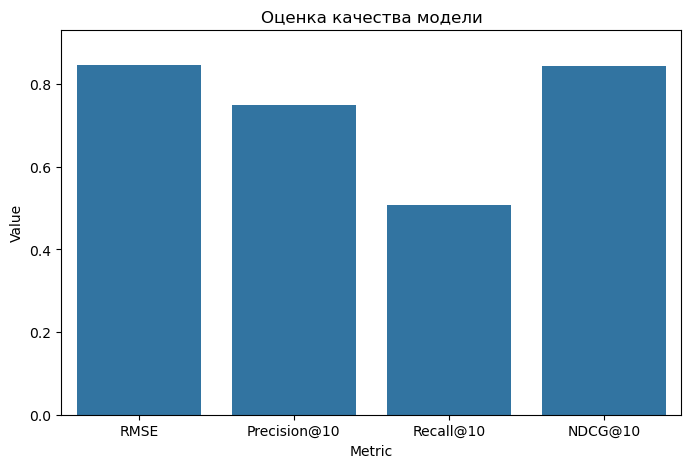

In [28]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Value', data=results_df)
plt.title("Оценка качества модели")
plt.ylim(0, max(results_df['Value'])*1.1)
plt.show()

5. Анализ результатов

Проанализируйте, какие рекомендации были наиболее удачными, а какие — 
неудачными. Предложите возможные улучшения для системы рекомендаций.

In [30]:
def analyze_recommendations(algo, user_id, movies_df, ratings_df, top_k=10, threshold=3.5):
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    high_rated = user_ratings[user_ratings['rating'] >= threshold]['movieId'].tolist()
    
    rated_movies = set(user_ratings['movieId'].tolist())
    all_movie_ids = set(movies_df['movieId'].unique())
    candidate_movies = list(all_movie_ids - rated_movies)
    
    predictions = []
    for movie_id in candidate_movies:
        pred = algo.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_predictions = predictions[:top_k]
    
    recs = []
    for movie_id, est in top_predictions:
        title = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].values[0]
        was_highly_rated = 'Yes' if movie_id in high_rated else 'No'
        recs.append({'movieId': movie_id, 'title': title, 'predicted_rating': est, 'was_highly_rated': was_highly_rated})
    
    recs_df = pd.DataFrame(recs)
    return recs_df

sample_user = 1
recs_df = analyze_recommendations(algo, sample_user, movies, ratings, top_k=10, threshold=3.5)

print("Рекомендации для user_id =", sample_user)
recs_df

Рекомендации для user_id = 1


,movieId,title,predicted_rating,was_highly_rated
0,318,"Shawshank Redemption, The (1994)",5.0,No
1,750,Dr. Strangelove or: How I Learned to Stop Worr...,5.0,No
2,858,"Godfather, The (1972)",5.0,No
3,904,Rear Window (1954),5.0,No
4,1199,Brazil (1985),5.0,No
5,1221,"Godfather: Part II, The (1974)",5.0,No
6,1228,Raging Bull (1980),5.0,No
7,1247,"Graduate, The (1967)",5.0,No
8,1252,Chinatown (1974),5.0,No
9,2019,Seven Samurai (Shichinin no samurai) (1954),5.0,No


### 2 часть

Цель: научиться создавать гибридную модель рекомендательной системы, 
которая использует как коллаборативную фильтрацию с разложением по 
сингулярным значениям (SVD), так и подход на основе содержимого.

In [30]:
from sklearn.model_selection import train_test_split

1. Подготовка данных

• Загрузите набор данных (например, MovieLens) и убедитесь, что у вас есть 
данные по рейтингам и информации о фильмах (жанры, описания и т. д.).\
• Разделите данные на обучающую и тестовую выборки.

In [31]:
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

train_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')

train_matrix.head()

movieId,1,2,3,5,6,7,9,10,11,12,...,166461,166528,166643,168250,168252,174055,176371,177765,179819,187593
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2. Реализация коллаборативной фильтрации с использованием SVD

• Импортируйте необходимые библиотеки и реализуйте модель SVD для 
коллаборативной фильтрации.

In [32]:
def compute_item_similarity(user_item_matrix):
    filled_matrix = user_item_matrix.fillna(0)
    similarity = cosine_similarity(filled_matrix.T)
    return pd.DataFrame(similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

def predict_rating_item_based(user, movie, user_item_matrix, item_similarity):
    user_ratings = user_item_matrix.loc[user]
    rated_items = user_ratings[user_ratings.notna()].index
    if len(rated_items) == 0:
        return np.nan
    sims = item_similarity.loc[movie, rated_items]
    ratings_vals = user_ratings[rated_items]
    numerator = (sims * ratings_vals).sum()
    denominator = sims.abs().sum()
    return numerator / denominator if denominator != 0 else np.nan

def compute_user_similarity(user_item_matrix):
    filled_matrix = user_item_matrix.fillna(0)
    similarity = cosine_similarity(filled_matrix)
    return pd.DataFrame(similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

def predict_rating_user_based(user, movie, user_item_matrix, user_similarity):
    ratings_for_item = user_item_matrix[movie]
    valid_users = ratings_for_item[ratings_for_item.notnull()].index.drop(user, errors='ignore')
    if len(valid_users) == 0:
        return np.nan
    sims = user_similarity.loc[user, valid_users]
    numerator = (sims * ratings_for_item.loc[valid_users]).sum()
    denominator = sims.abs().sum()
    return numerator / denominator if denominator != 0 else np.nan

item_similarity = compute_item_similarity(train_matrix)
user_similarity = compute_user_similarity(train_matrix)

reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))
data_train = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset_svd = data_train.build_full_trainset()

svd_algo = SVD(n_factors=100, n_epochs=20, random_state=42)
svd_algo.fit(trainset_svd)

item_preds = []
user_preds = []
svd_preds = []
ensemble_preds = []
actuals = []

for idx, row in test_df.iterrows():
    user = row['userId']
    movie = row['movieId']
    actual = row['rating']
    
    if user in train_matrix.index and movie in train_matrix.columns:
        pred_item = predict_rating_item_based(user, movie, train_matrix, item_similarity)
        pred_user = predict_rating_user_based(user, movie, train_matrix, user_similarity)
    else:
        pred_item = np.nan
        pred_user = np.nan
        
    pred_svd = svd_algo.predict(user, movie).est
    
    preds = []
    if not np.isnan(pred_item):
        preds.append(pred_item)
    if not np.isnan(pred_user):
        preds.append(pred_user)
    if not np.isnan(pred_svd):
        preds.append(pred_svd)
    
    if len(preds) == 0:
        continue 
    ensemble_pred = np.mean(preds)
    
    item_preds.append(pred_item)
    user_preds.append(pred_user)
    svd_preds.append(pred_svd)
    ensemble_preds.append(ensemble_pred)
    actuals.append(actual)

def compute_metrics(true, preds):
    rmse = np.sqrt(mean_squared_error(true, preds))
    mae = mean_absolute_error(true, preds)
    return rmse, mae

item_actuals = [a for p, a in zip(item_preds, actuals) if not np.isnan(p)]
item_preds_valid = [p for p in item_preds if not np.isnan(p)]
rmse_item, mae_item = compute_metrics(item_actuals, item_preds_valid)

user_actuals = [a for p, a in zip(user_preds, actuals) if not np.isnan(p)]
user_preds_valid = [p for p in user_preds if not np.isnan(p)]
rmse_user, mae_user = compute_metrics(user_actuals, user_preds_valid)

rmse_svd, mae_svd = compute_metrics(actuals, svd_preds)
rmse_ensemble, mae_ensemble = compute_metrics(actuals, ensemble_preds)

print("Метрики для Item-Based CF:")
print(f"  RMSE: {rmse_item:.3f}, MAE: {mae_item:.3f}")

print("\nМетрики для User-Based CF:")
print(f"  RMSE: {rmse_user:.3f}, MAE: {mae_user:.3f}")

print("\nМетрики для SVD:")
print(f"  RMSE: {rmse_svd:.3f}, MAE: {mae_svd:.3f}")

print("\nМетрики для Ensemble (усреднение всех методов):")
print(f"  RMSE: {rmse_ensemble:.3f}, MAE: {mae_ensemble:.3f}")

Метрики для Item-Based CF:
  RMSE: 0.909, MAE: 0.700

Метрики для User-Based CF:
  RMSE: 0.942, MAE: 0.730

Метрики для SVD:
  RMSE: 0.855, MAE: 0.655

Метрики для Ensemble (усреднение всех методов):
  RMSE: 0.860, MAE: 0.661


3. Реализация контентной фильтрации

• Извлеките и обработайте признаки фильмов, используя TF-IDF или другие 
методы для представления контента (жанры, описания).

In [33]:
tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim, movies=movies, indices=indices, top_n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies[['movieId', 'title', 'genres']].iloc[movie_indices]

recommendations = get_recommendations("Toy Story (1995)")
recommendations

,movieId,title,genres
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
6486,53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy


4. Объединение моделей

• Реализуйте метод объединения оценок, полученных из SVD и контентного 
подхода. Это может быть простое среднее или более сложная модель 
(например, взвешенное среднее).

In [34]:
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))
data_train = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset_svd = data_train.build_full_trainset()

svd_algo = SVD(n_factors=100, n_epochs=20, random_state=42)
svd_algo.fit(trainset_svd)


movies['genres'] = movies['genres'].replace('(no genres listed)', '')

tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

movieId_to_index = pd.Series(movies.index, index=movies['movieId']).to_dict()

def predict_rating_content_based(user, movie, user_item_matrix, cosine_sim, movies, movieId_to_index):
    if movie not in movieId_to_index:
        return np.nan
    user_ratings = user_item_matrix.loc[user]
    rated_movies = user_ratings[user_ratings.notna()].index
    if len(rated_movies) == 0:
        return np.nan
    target_idx = movieId_to_index[movie]
    sim_scores = []
    ratings_vals = []
    for m in rated_movies:
        if m not in movieId_to_index:
            continue
        rated_idx = movieId_to_index[m]
        sim = cosine_sim[target_idx, rated_idx]
        sim_scores.append(sim)
        ratings_vals.append(user_ratings[m])
    sim_scores = np.array(sim_scores)
    ratings_vals = np.array(ratings_vals)
    if sim_scores.sum() == 0:
        return np.nan
    return (sim_scores * ratings_vals).sum() / sim_scores.sum()

def predict_rating_hybrid(user, movie, user_item_matrix, cosine_sim, movies, movieId_to_index, svd_algo):
    pred_svd = svd_algo.predict(user, movie).est
    pred_content = np.nan
    if user in user_item_matrix.index:
        pred_content = predict_rating_content_based(user, movie, user_item_matrix, cosine_sim, movies, movieId_to_index)
    if not np.isnan(pred_svd) and not np.isnan(pred_content):
        return (pred_svd + pred_content) / 2.0
    elif not np.isnan(pred_svd):
        return pred_svd
    elif not np.isnan(pred_content):
        return pred_content
    else:
        return np.nan
    


hybrid_preds = []
actuals = []
predictions_for_metrics = [] 

for idx, row in test_df.iterrows():
    user = row['userId']
    movie = row['movieId']
    true_rating = row['rating']
    
    hybrid_pred = predict_rating_hybrid(user, movie, train_matrix, cosine_sim, movies, movieId_to_index, svd_algo)
    
    if np.isnan(hybrid_pred):
        continue
    hybrid_preds.append(hybrid_pred)
    actuals.append(true_rating)
    predictions_for_metrics.append((user, movie, true_rating, hybrid_pred, None))

5. Оценка гибридной модели

• Оцените качество модели с помощью метрик, таких как RMSE, Precision и 
Recall, и сравните результаты с коллаборативной и контентными моделями 
по отдельности.

In [35]:
rmse_hybrid = np.sqrt(mean_squared_error(actuals, hybrid_preds))
mae_hybrid = mean_absolute_error(actuals, hybrid_preds)

print("Гибридная модель (SVD + Контент):")
print(f"  RMSE: {rmse_hybrid:.3f}")
print(f"  MAE:  {mae_hybrid:.3f}")

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) 
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / (n_rec_k + 1e-10)
        recalls[uid] = n_rel_and_rec_k / (n_rel + 1e-10)
    return precisions, recalls

precisions, recalls = precision_recall_at_k(predictions_for_metrics, k=10, threshold=3.5)
avg_precision = np.mean(list(precisions.values()))
avg_recall = np.mean(list(recalls.values()))

print("\nОценка top-10 рекомендаций (гибридная модель):")
print(f"  Precision@10: {avg_precision:.4f}")
print(f"  Recall@10:    {avg_recall:.4f}")

Гибридная модель (SVD + Контент):
  RMSE: 0.858
  MAE:  0.659

Оценка top-10 рекомендаций (гибридная модель):
  Precision@10: 0.7204
  Recall@10:    0.5242
